In [2]:
import numpy as np 
import matplotlib.pyplot as plt



/Users/lucasspencer/opt/anaconda3/envs/plaidml/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


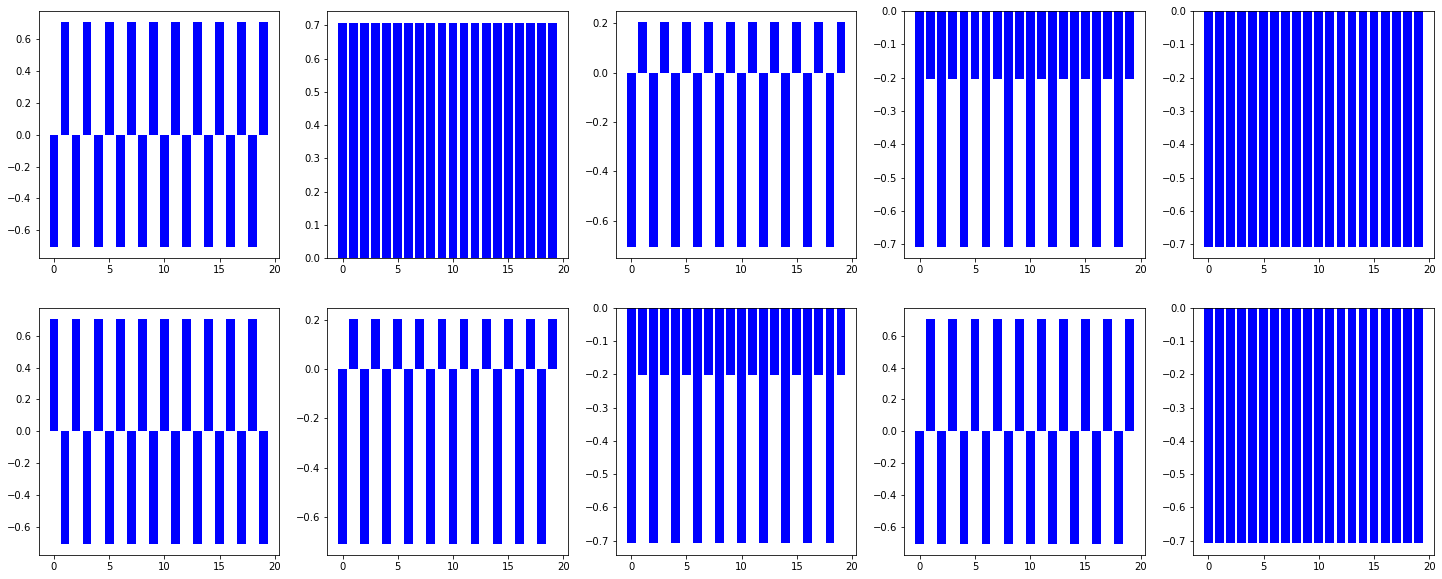

In [140]:
def is_even(n):
    return n//2 * 2 == n

# define the SSH hamiltonian
def ssh_finite(v,w, N):
    # need N to be even
    if not is_even(N):
        raise Exception("N must be even")

    # Create the matrix
    mat = np.zeros((N, N))
    
    for k in range(0,N//2):
        i = 2 * k
        mat[i][i+1] = v
        mat[i+1][i] = v
        if i + 2 < N:
            mat[i+1][i+2] = w
            mat[i+2][i+1] = w
    
    # Compute eigenvectors
    eigs, vecs = np.linalg.eigh(mat)
    return eigs, vecs.T

def ssh_bulk(v, w, N):
    # Compute the spacings for the wave number
    k_range = np.linspace(0,2 *np.pi, N//2)

    # Compute the eigenvalues and eigenvectors for a specific wave numebr
    def k_eigs(k):
        mat = np.array([
            [0, v + w * np.exp(-1j*k)],
            [v + w * np.exp(1j*k),0]
        ])

        return np.linalg.eigh(mat)

    # Compute all eigenvalues and vectors
    eigs = []
    evecs = []
    for k in k_range:
        eig, vecs = k_eigs(k)

        eigs += list(eig)
        evecs += list(vecs.T)

    return np.array(eigs), np.array(evecs)

# Eigenvector plotting
# splits into +ve negative eigenvectors
def plot_eigs(eigs):
    p_eigs = np.sort(eigs[eigs>0])
    n_eigs = np.sort(eigs[eigs<0])[::-1]

    plt.plot(p_eigs)
    plt.plot(n_eigs)

# Plots an eigenvector
def plot_eigvec(vec):
    plt.bar(list(range(0,len(vec))),vec)

def plot_periodic_eigvec(vec, N=10):
    l = len(vec)
    for i in range(0, N):
        plt.bar(list(range(i * l, (i+1) * l)), vec, color='blue')

plt.figure(figsize=(25,10))
for i in range(0,10):
    plt.subplot(2,5,i + 1)      
    plot_periodic_eigvec(ssh_bulk(0.3,1,10)[1][i])

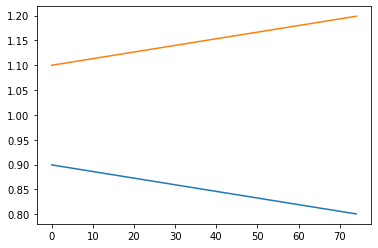

In [175]:
# Define the toy model hamiltonian

def toy_finite(v, N, epsilon):
    # need N to be even
    if not is_even(N):
        raise Exception("N must be even")

    mat = np.zeros((N,N))
    for k in range(0,N//2):
        i = 2 * k
        mat[i][i+1] = v(i, epsilon)
        mat[i+1][i] = v(i, epsilon)
        if i + 2 < N:
            mat[i+1][i+2] = v(i+1, epsilon)
            mat[i+2][i+1] = v(i+1, epsilon)
    
     # Compute eigenvectors
    eigs, vecs = np.linalg.eigh(mat)
    return eigs, vecs.T

def linear_perturbation(N, start=0, end=1, base_size=0.1):
    def v(i, epsilon):
        return 1 + (-1)**i * (epsilon * i * (end - start)/ N + base_size)

    return v

def tanh_perturbation(N, rate=0.05):
    def v(i, epsilon):
        return 1 + (-1)** i * (epsilon * np.tanh((i - N//2 + 1) * rate) + base_size)
    
    return v

def plot_pert(perturbation, N, epsilon=0.1):
    r = list(range(0,N//2))
    perts = []

    for i in range(0,N):
        perts.append(perturbation(i, epsilon))
    
    perts = np.array(perts)
    ws = perts[perts<1]
    vs = perts[perts>1]

    plt.plot(list(range(0,len(ws))), ws)
    plt.plot(list(range(0,len(vs))), vs)

plot_pert(linear_perturbation(150),150)


# plot_eigs(toy_finite(tanh_perturbation(100),100)[0])
# plot_eigs(ssh_finite(1.0,1.0,100)[0])


In [333]:
# Now introduce time dependent polarization computations, this involves slowly turning on the perturbation (epsilon 0 -> e)
# We can use the previously defined toy model to compute the instantaneous eigenvectors/values

def toy_finite_hamiltonian(perturbation, N):
    def H(epsilon):
        return toy_finite(perturbation, N, epsilon)
    
    return H

# Compute the right charge operator expectation
def right_charge(a, bra, ket):
    # Formally Q is a matrix of size N * N with 1's on the diagonal for indicies i >= a else 0
    # So its the following inner product
    return np.dot(bra[a:], ket[a:])

# Compute the current contribution from each eigenvector at each timestep
def single_eig_current(H, a, min_e = 0, max_e = 0.9, timesteps=100):
    # Compute all eigenvectors for each step 
    vecs = []
    eigs = []
    epsilon_step = (max_e - min_e)/timesteps
    for t in range(0, timesteps):
        t_eigs, t_vecs = H(t * epsilon_step)

        vecs.append(t_vecs)
        eigs.append(t_eigs)
    
    vecs = np.array(vecs)
    eigs = np.array(eigs)

    # Now compute the gradients of the vecs across the timesteps
    vec_grads = np.gradient(vecs)[0]

    # From above we now have the instantaneous eigenvectors and can now compute the required expectations
    # In the toy model we will always have real eigenvectors because the hamiltonian is symmetric and real, in general this may not be the case.
    currents = np.zeros((timesteps, len(vecs[0])))
    
    for t in range(0, timesteps):
        vec_t = vecs[t]
        vec_grad_t = vec_grads[t]
        for i in range(0, len(vecs[0])):
            for j in range(0, len(vecs[0])):
                # Compute the contribution from the m'th eigenvector to the n'th current
                nQm = right_charge(a, vec_t[i], vec_t[j])
                mQn = right_charge(a, vec_t[j], vec_t[i])

                mDn = np.dot(vec_t[j],vec_grad_t[t][i])
                Dnm = np.conjugate(mDn)


    
single_eig_current(toy_finite_hamiltonian(linear_perturbation(20), 20),1,  timesteps=10)


In [223]:
a = np.array([
    [[1,2],[1,2]],
    [[2,3],[3,3]]
])

print(np.gradient(a)[0][0])
print(a[1][1] - a[0][1])

[[1. 1.]
 [2. 1.]]
[2 1]
